In [7]:
%load_ext autoreload
%autoreload 2

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
# set tf to cpu only
tf.config.set_visible_devices([], 'GPU')

import jax
jax.config.update('jax_platform_name', 'cpu')


from typing import Any
import numpy as np
import matplotlib.pyplot as plt 

# fake dataset
from waymax import config as _config
from waymax import visualization
from waymax import datatypes
# from waymax.dynamics.bicycle_model import compute_inverse
from rl_env.waymax_util import WomdLoader
from rl_env.env_utils import merge_dict, process_input
import mediapy

from scipy.signal import savgol_filter
import copy
from waymax.datatypes import SimulatorState, Trajectory
import jax.numpy as jnp
from scipy.interpolate import interp1d
from waymax.utils.geometry import wrap_yaws

n_agent = 64

WOMD_1_2_0_VAL_LOCAL = _config.DatasetConfig(
    # path='/Data/Dataset/Waymo/V1_2_tf/validation_interactive/validation_interactive_tfexample.tfrecord@150',
    path='/Data/Dataset/Waymo/V1_2_tf/validation/validation_tfexample.tfrecord@150',
    # path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord@1000',
    max_num_rg_points=30000,
    data_format=_config.DataFormat.TFRECORD,
    max_num_objects=None,
    # shuffle_seed = 0,
)
data_iter = WomdLoader(data_config=WOMD_1_2_0_VAL_LOCAL)


from rl_env.waymax_env import MultiAgentEnvironment
import dataclasses
from waymax import dynamics
from waymax.agents import actor_core

from rl_env.env_utils import inverse_control, smooth_scenario


dynamics_model = dynamics.InvertibleBicycleModel()
# Expect users to control all valid object in the scene.
env = MultiAgentEnvironment(
    dynamics_model=dynamics_model,
    config=dataclasses.replace(
        _config.EnvironmentConfig(),
        init_steps = 1,
        # max_num_objects=n_agent,
        controlled_object=_config.ObjectType.MODELED,
        rewards = _config.LinearCombinationRewardConfig(
            rewards={
                'overlap': 1.0, # Positive is good.  
                'offroad': 1.0, # Negative is good.
                'kinematics': 1.0, # Negative is good.
            }
        )
    ),
)


b1a62b81ab2e557c


""

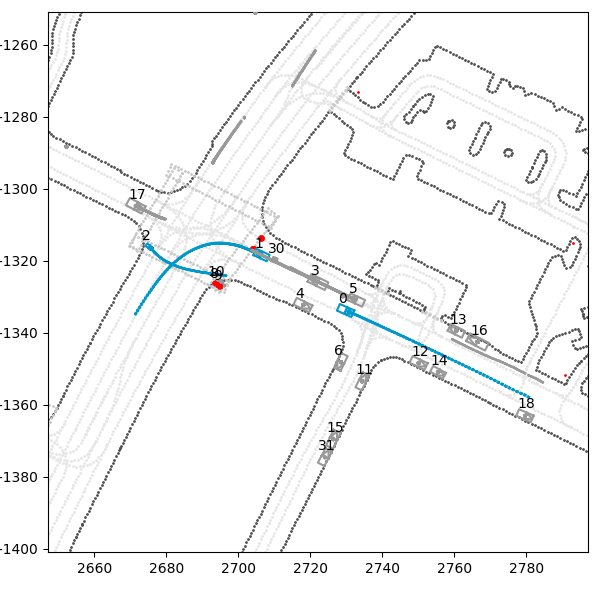

In [14]:
scenario_id, scenario = data_iter.next()
print(scenario_id)
img = visualization.plot_simulator_state(scenario, use_log_traj=True, highlight_obj = _config.ObjectType.MODELED)
mediapy.show_image(img)

In [15]:
action, action_valid = inverse_control(scenario)
is_controlled = scenario.object_metadata.is_modeled | scenario.object_metadata.is_sdc
states = [env.reset(scenario)]
for i in range(states[0].remaining_timesteps):
  current_state = states[-1]
  t = current_state.timestep
  
  waymax_action = actor_core.WaymaxActorOutput(
            action=datatypes.Action(data=jnp.asarray(action[:,t,:]), valid=action_valid[:, t:t+1]),
            actor_state=None,
            is_controlled=is_controlled
        )
  next_state = env.step_sim_agent(current_state, [waymax_action])
  states.append(next_state)

In [ ]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=False, highlight_obj = _config.ObjectType.VALID))
mediapy.show_video(imgs, fps=10)

In [ ]:
imgs = []
for state in states:
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=True, highlight_obj = _config.ObjectType.VALID))
mediapy.show_video(imgs, fps=10)

# Test Smoothing

In [ ]:
# scenario_id, scenario = data_iter.next()

# Scenario smoothing
scenario_smoothed = smooth_scenario(copy.deepcopy(scenario))
vel_raw = np.stack(
    [scenario.log_trajectory.vel_x, scenario.log_trajectory.vel_y], axis=-1
)
vel = np.stack(
    [scenario_smoothed.log_trajectory.vel_x, scenario_smoothed.log_trajectory.vel_y], axis=-1
  )
speed_raw = np.linalg.norm(vel_raw, axis=-1)
speed = np.linalg.norm(vel, axis=-1)
accel_raw = np.diff(speed_raw, axis=-1) / 0.1
accel = np.diff(speed, axis=-1) / 0.1

delta_yaw_raw = wrap_yaws(np.diff(scenario.log_trajectory.yaw, axis=-1))
delta_yaw = wrap_yaws(np.diff(scenario_smoothed.log_trajectory.yaw, axis=-1))
steering_raw = delta_yaw_raw / (speed_raw[:, :-1]*0.1+0.5*accel_raw*0.01 + 1e-5)
steering = delta_yaw / np.clip((speed[:, :-1]*0.1+0.5*accel*0.01), 0.1, None)
steering = np.where(speed[..., :-1] > 0.6, steering, 0)

valid = np.asarray(scenario_smoothed.log_trajectory.valid)
valid_accel = np.logical_and(valid[:, :-1], valid[:, 1:])
i=0
t = np.arange(0, 9.1, 0.1)
t_accel = t[:-1]

for i in range(32):
  if scenario_smoothed.object_metadata.is_valid[i] == 0:
    continue
  fig, axs = plt.subplots(1, 3, figsize=(15, 2))
  axs[0].plot(t[valid[i]], speed_raw[i][valid[i]], 'k--')
  axs[0].plot(t_accel[valid_accel[i]], accel_raw[i][valid_accel[i]], 'r--')

  axs[0].plot(t[valid[i]], speed[i][valid[i]], 'k-')
  axs[0].plot(t_accel[valid_accel[i]], accel[i][valid_accel[i]], 'r-')
  axs[0].set_title(f"{i} v")

  axs[1].plot(t[valid[i]], scenario.log_trajectory.yaw[i][valid[i]], 'b--')
  axs[1].plot(t[valid[i]], scenario_smoothed.log_trajectory.yaw[i][valid[i]], 'b-')
  # axs[1].plot(t[valid[i]], np.arctan2(scenario_smoothed.log_trajectory.vel_y, scenario_smoothed.log_trajectory.vel_x)[i][valid[i]], 'r--')
  axs[1].set_title(f"{i} yaw")
  axs[1].set_ylim(-3.2, 3.2)

  axs[2].plot(t_accel[valid_accel[i]], steering_raw[i][valid_accel[i]]/0.3, 'b--') 
  axs[2].plot(t_accel[valid_accel[i]], steering[i][valid_accel[i]]/0.3, 'b-')
  # axs[2].plot(t_accel[valid_accel[i]], beta[i][valid_accel[i]]/0.3, 'r--')
  axs[2].set_ylim(-1.5, 1.5)
  axs[2].set_title(f"{i} steering")

In [20]:
a = np.random.randint(0,2, size=(2, 2))
b = np.random.randint(0,2, size=(2, 1))
print(a)
print(b)
np.logical_and(a, b)


[[0 1]
 [0 1]]
[[1]
 [0]]


array([[False,  True],
       [False, False]])